# Laboratorium 3 - segmentacje

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 scikit-learn==1.3.2 wordcloud==1.8.1`

## Część 1. - przygotowanie danych

*Zadziałało na wersji Pythona 3.9.12 (na 3.11.x nie działa)*

In [1]:
%pip install gensim==3.8.3 scikit-learn==1.3.2 wordcloud==1.8.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importujemy potrzebne pakiety

from collections import Counter, defaultdict
import codecs
import csv

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, silhouette_samples
from wordcloud import WordCloud

In [3]:
PATH = 'socialmediadata-beeradvocate/data/beer_reviews.csv'
SCORE_THRESHOLD = 4 # recenzje z co najmniej taka ocena wezmiemy pod uwage
VECTOR_SIZE = 20 # jak dlugie powinny byc wektory osadzen uzytkownikow
SEGMENTS_COUNT = 10 # na ile segmentow chcemy podzielic populacje uzytkownikow

In [4]:
# wczytujemy dane

def parse_headers(column_names):
    beer_id_column =  column_names.index('beer_beerid')
    beer_style_column = column_names.index('beer_style')
    user_id_column =  column_names.index('review_profilename')
    score_column =  column_names.index('review_overall')
    return beer_id_column, beer_style_column, user_id_column, score_column

def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return line[beer_id_column], line[beer_style_column], line[user_id_column], float(line[score_column])

def read_and_parse_reviews(path, score_threshold):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        data_reader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(data_reader))
    
        users_favourite_beers = defaultdict(list)
        for review in data_reader:
            beer_id, _, user_id, score = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            if score >= score_threshold:
                users_favourite_beers[user_id].append(beer_id)

    return users_favourite_beers

def get_beer_id_to_style_mapping(path):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        data_reader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(data_reader))
        beer_styles = {}
        for review in data_reader:
            beer_id, beer_style, _, _ = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            beer_styles[beer_id] = beer_style
        return beer_styles

# otrzymujemy slownik - mapowanie z user_id na liste ulubionych beer_ids
users_favourite_beers = read_and_parse_reviews(PATH, SCORE_THRESHOLD)

# dodatkowo przygotujmy sobie slownik mapujacy id piwa na nazwe stylu
beer_styles = get_beer_id_to_style_mapping(PATH)

## Część 2. - osadzenia użytkowników

In [5]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

model = Word2Vec(sentences=users_favourite_beers.values(), size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [6]:
# na podstawie modelu obliczamy wektorowa reprezentacje uzytkownikow

def get_mean_vector_for_user(user_favourite_beers, model, vector_size):
    # inicjalizujemy wektor zerami
    v = np.zeros(vector_size)
    
    # iterujemy po liscie user_favourite_beers, odczytujemy z modelu wektor reprezentujacy kazde piwo i dodajemy do wektora
    #   uzyj: model.wv[beer_id]
    for beer_id in user_favourite_beers:
        v += model.wv[beer_id]
    
    # normalizujemy wektor - dzielimy kazda wspolrzedna przez liczbe piw
    v /= len(user_favourite_beers)
    
    return v

def get_mean_user_vectors(users_favourite_beers, model, vector_size):
    # korzystajac z powyzszej funkcji, tworzymy slownik {user_id -> vector}
    mean_users_vectors = {}
    
    for user_id, user_favourite_beers in users_favourite_beers.items():
        mean_users_vectors[user_id] = get_mean_vector_for_user(user_favourite_beers, model, vector_size)
    
    return mean_users_vectors

user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)
user_vectors

{'johnmichaelsen': array([-0.03268365, -0.06560661,  0.32426546, -0.55849724, -0.39372788,
        -0.01577831, -1.0081596 ,  0.18803964,  0.04396534, -0.43601121,
        -0.2723287 ,  0.26428828, -0.15390647,  0.18877856, -0.23894886,
         1.0405408 ,  1.48079235, -0.00451268,  0.41761345, -1.43906001]),
 'LordAdmNelson': array([ 0.24862805,  0.0671628 ,  0.01207264, -1.10819621, -0.147644  ,
         0.09504056, -1.82408972,  0.14172355,  0.10714413, -1.01035986,
        -0.06482911,  0.38725573,  0.50677739,  0.22225889, -0.45509153,
         1.75481392,  2.52765628,  0.26026318,  1.01647383, -2.31088517]),
 'augustgarage': array([-0.05620232, -0.20732159,  0.45979225, -0.75594134, -0.58873112,
        -0.06700371, -1.27593158,  0.30850595,  0.05590137, -0.64736127,
        -0.19245228,  0.39248768, -0.06802007,  0.17242788, -0.21766769,
         1.21168302,  1.83312982, -0.10600491,  0.51825513, -1.90375455]),
 'MadeInOregon': array([-0.22685827,  0.47802075, -0.31632204, -0.1

## Część 3. - klasteryzacja

In [7]:
# klastrujemy uzytkownikow - mozemy uzyc wielu algorytmow, np k-means, agglomerative, BIRCH, ...

def get_users_segmentation(user_vectors, vector_size, segments_count, clustering_algorithm):
    # rozkladamy slownik user_vectors na liste uzytkownikow i liste wektorow
    #  - wazne jest zachowanie tej samej kolejnosci w obu listach
    users = user_vectors.keys()
    vectors = user_vectors.values()
    
    # zamieniamy liste wektorow w macierz
    users_array = np.stack(tuple(vectors), axis=0)
    # zaimplementuj wsparcie dla co najmniej jednego algorytmu wiecej
    if clustering_algorithm == 'agglomerative':
        clustering = AgglomerativeClustering(n_clusters=segments_count).fit_predict(users_array)
        # clustering to lista przypisanych klastrow - i-ty element to klaster, do ktorego nalezy i-ty wektor
    elif clustering_algorithm == 'kmeans':
        clustering = KMeans(n_clusters=segments_count).fit_predict(users_array)
    elif clustering_algorithm == 'birch':
        clustering = Birch(n_clusters=segments_count).fit_predict(users_array)
    
    segmentation = {}
    # jesli nie pomieszalismy kolejnosci w listach, to mozemy odzyskac mapping user_id -> cluster
    
    for i, user_id in enumerate(users):
        segmentation[user_id] = clustering[i]
    
    return segmentation

segmentation = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'agglomerative')
# segmentation = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'kmeans')
# segmentation = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'birch')

In [8]:
segmentation

{'johnmichaelsen': 0,
 'LordAdmNelson': 0,
 'augustgarage': 0,
 'MadeInOregon': 0,
 'rawthar': 0,
 'Halcyondays': 0,
 'beerguy101': 0,
 'UCLABrewN84': 0,
 'zaphodchak': 0,
 'Tilley4': 0,
 'mikedrinksbeer2': 0,
 'dbmernin83': 0,
 'titosupertramp': 0,
 'optimator13': 0,
 'Blakaeris': 0,
 'bashiba': 0,
 'Klym': 0,
 'flexabull': 0,
 'Bung': 0,
 'oberon': 0,
 't420o': 0,
 'DarthKostrizer': 0,
 'MrVonzipper': 0,
 'TheWhiskerReview': 0,
 'Jason': 0,
 'DoubleJ': 0,
 'Deuane': 0,
 'Mattybeerguy': 9,
 'micromaniac129': 0,
 'northyorksammy': 0,
 'vette2006c5r': 0,
 'EvanEngelstad': 9,
 'djeucalyptus': 0,
 'ccrida': 0,
 'brewandbbq': 0,
 'hopsbreath': 0,
 'Slatetank': 0,
 'Proteus93': 0,
 'SShelly': 0,
 'zoso1967': 0,
 'msubulldog25': 0,
 'NJpadreFan': 0,
 'd0ggnate': 0,
 'Cyberkedi': 0,
 'babyhobbes': 0,
 'mdagnew': 0,
 'mikesgroove': 0,
 'hdofu': 0,
 'GratefulBeerGuy': 0,
 'PDXHops': 0,
 'IMincedTheKing': 0,
 'Goliath': 0,
 'zeff80': 0,
 'akorsak': 0,
 'wchesak': 0,
 'bfields4': 0,
 'dyan': 0,
 

In [9]:
# obliczamy licznosci segmentow

def get_segment_sizes(segmentation):
    return Counter(segmentation.values())

get_segment_sizes(segmentation)

Counter({0: 15228,
         9: 4811,
         5: 1565,
         1: 2496,
         3: 2594,
         2: 1058,
         6: 1094,
         4: 386,
         7: 680,
         8: 374})

In [10]:
# obliczamy metryke jakosci segmentacji
# metryka przyjmuje wartosci [-1, 1] - im wiecej, tym lepiej
users, user_vectors_list = zip(*user_vectors.items())
segments_list = [segmentation[u] for u in users]

mean_silhouette = silhouette_score(user_vectors_list, segments_list, metric='euclidean')
per_sample_silhouettes = silhouette_samples(user_vectors_list, segments_list, metric='euclidean')

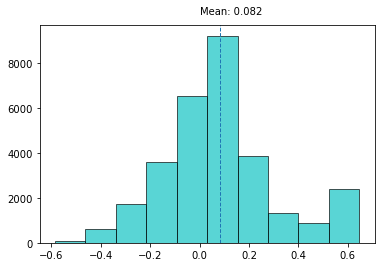

In [11]:
# rysujemy wykres
def plot_histogram(values, mean_value):
    plt.hist(values, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(mean_value, linestyle='dashed', linewidth=1)
    _, plot_height = plt.ylim()
    plt.text(0, plot_height*1.05, 'Mean: {:.3f}'.format(mean_value))
    plt.show()

plot_histogram(per_sample_silhouettes, mean_silhouette)

## Część 4. - opisy segmentów

In [12]:
# obliczamy popularnosc styli w segmentach oraz w calej populacji
#  - czyli jak czesto kazdy ze styli wystepowal

def get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, segments_count):
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]
    
    for user, beers in users_favourite_beers.items():
        segment = segmentation[user]
        for beer in beers:
            beer_styles_per_segment[segment][beer_styles[beer]] += 1
    
    return beer_styles_per_segment

def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)

    for segment_popularity in beer_styles_per_segment.values():
        for style, popularity in segment_popularity.items():
            total_popularity[style] += popularity
    
    return total_popularity

per_segment_styles_popularity = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, SEGMENTS_COUNT)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

In [13]:
list(per_segment_styles_popularity.items())[0][1]

defaultdict(<function __main__.get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda>()>,
            {'American Double / Imperial IPA': 60265,
             'Keller Bier / Zwickel Bier': 1599,
             'American IPA': 80016,
             'Russian Imperial Stout': 39198,
             'Märzen / Oktoberfest': 12709,
             'American Double / Imperial Stout': 36959,
             'Rye Beer': 7171,
             'American Strong Ale': 20604,
             'Old Ale': 9593,
             'Saison / Farmhouse Ale': 21864,
             'Doppelbock': 13401,
             'Rauchbier': 2264,
             'Munich Helles Lager': 4498,
             'Czech Pilsener': 6867,
             'English Strong Ale': 2619,
             'German Pilsener': 11160,
             'English Barleywine': 8358,
             'Belgian IPA': 8637,
             'Berliner Weissbier': 2232,
             'Tripel': 19395,
             'Belgian Strong Dark Ale': 24744,
             'American Double / Imperial Pilsner'

In [14]:
# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
#   oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
#   dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}

def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    return {segment_id: dict(Counter(segment_popularity).most_common(N))
        for segment_id, segment_popularity in per_segment_styles_popularity.items()}

def most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, N):
    return {segment_id: dict(Counter({ 
            style_id: segment_popularity[style_id] / total_popularity 
                for style_id, total_popularity in total_styles_popularity.items() 
            }).most_common(N))
        for segment_id, segment_popularity in per_segment_styles_popularity.items()}

top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, top_N)

## Część 5. - wizualizacja

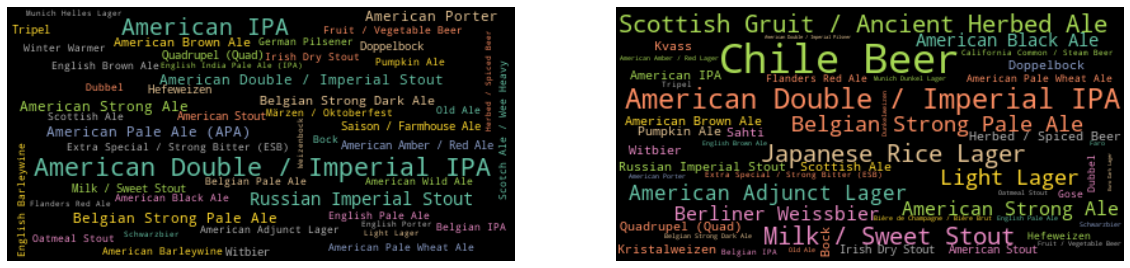

In [15]:
# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
#   zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami

def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    wordcloud1 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()
    
visualise_styles(most_popular, most_distinctive, 3)